# Import dataset

In [1]:
! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
! pip install --upgrade --force-reinstall --no-deps kaggle
!kaggle competitions download -c ventilator-pressure-prediction -p 'dataset'

Saving kaggle.json to kaggle (2).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists
ref                                                         title                                              size  lastUpdated          downloadCount  voteCount  usabilityRating  
----------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
gpreda/reddit-vaccine-myths                                 Reddit Vaccine Myths                              237KB  2021-12-12 11:59:54          18476       1436  1.0              
crowww/a-large-scale-fish-dataset                           A Large Scale Fish Dataset                          3GB  2021-04-28 17:03:01          11147        782  0.9375           
imsparsh/musicnet-dataset                                   MusicNet Dataset                                   22GB  2021-02-18 14:12:19           5702        369  1.0       

In [2]:
cd dataset

/content/dataset


In [3]:
! unzip ventilator-pressure-prediction.zip

Archive:  ventilator-pressure-prediction.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [4]:
import pandas as pd

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submission.csv')

#EDA

How many unique values do we have in each column?

In [5]:
print('train rows count: {} \n\n'.format(
    len(train)))

for i in train.columns:
  unq = train[i].unique()
  print('{} \n unique values count: {} \n unique values: {} \n'.format(
      i, len(unq), unq if len(unq) <= 20 else '{} (...)'.format(unq[:11])))

train rows count: 6036000 


id 
 unique values count: 6036000 
 unique values: [ 1  2  3  4  5  6  7  8  9 10 11] (...) 

breath_id 
 unique values count: 75450 
 unique values: [ 1  2  3  4  5  6  7  9 10 12 13] (...) 

R 
 unique values count: 3 
 unique values: [20 50  5] 

C 
 unique values count: 3 
 unique values: [50 20 10] 

time_step 
 unique values count: 3767571 
 unique values: [0.         0.03365231 0.06751442 0.10154223 0.13575554 0.16969776
 0.20370793 0.23772264 0.27177644 0.30573177 0.33967495] (...) 

u_in 
 unique values count: 4020248 
 unique values: [ 0.08333401 18.38304147 22.50927777 22.80882226 25.3558503  27.25986586
 27.12748564 26.80773177 27.8647154  28.31303579 26.86675822] (...) 

u_out 
 unique values count: 2 
 unique values: [0 1] 

pressure 
 unique values count: 950 
 unique values: [ 5.83749171  5.90779385  7.87625392 11.74287192 12.23498694 12.86770625
 14.69556203 15.8906985  15.53918778 15.75009421 17.29674141] (...) 



Check if R is individual for each Breath_ID

In [6]:
train.groupby('breath_id').mean()['R'].unique()

array([20., 50.,  5.])

Means of R for each breath_id are the same as unique values, what means that each R is the same for same breath_id

Check if C is individual for each Breath_ID

In [7]:
train.groupby('breath_id').mean()['C'].unique()

array([50., 20., 10.])

Check if u_out is individual for each Breath_ID

In [8]:
train.groupby('breath_id').mean()['u_out'].unique()

array([0.625 , 0.6375, 0.6   , 0.6125, 0.65  , 0.6875, 0.675 ])

Means for u_out of each breath_id are different so same breath_id doesn't mean same u_out

In [9]:
train[train['breath_id'] == 5].corr()

,id,breath_id,R,C,time_step,u_in,u_out,pressure
id,1.000000,NaN,NaN,NaN,1.000000,-0.766030,0.832700,-0.669351
breath_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
R,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
C,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
time_step,1.000000,NaN,NaN,NaN,1.000000,-0.765779,0.832506,-0.669385
u_in,-0.766030,NaN,NaN,NaN,-0.765779,1.000000,-0.950948,0.560752
u_out,0.832700,NaN,NaN,NaN,0.832506,-0.950948,1.000000,-0.710004
pressure,-0.669351,NaN,NaN,NaN,-0.669385,0.560752,-0.710004,1.000000


Plot correlated features

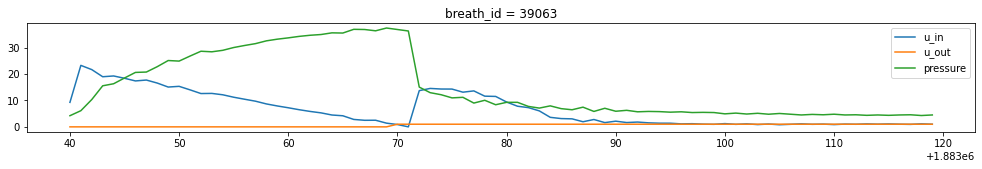

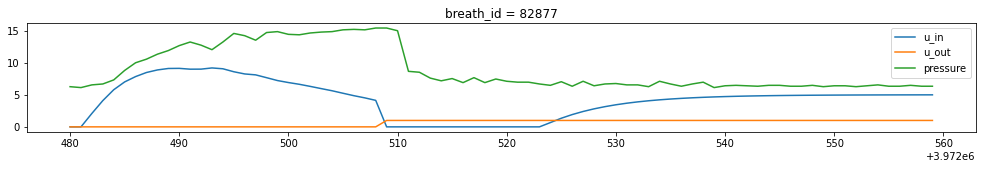

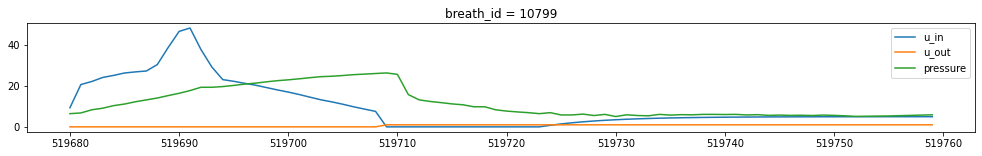

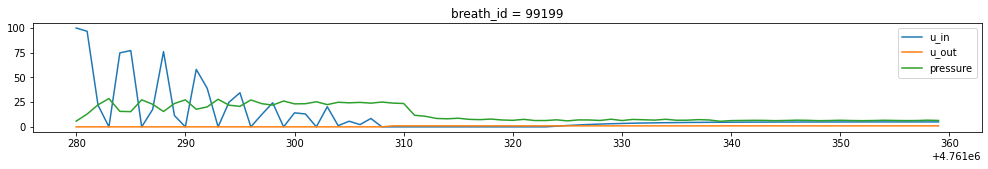

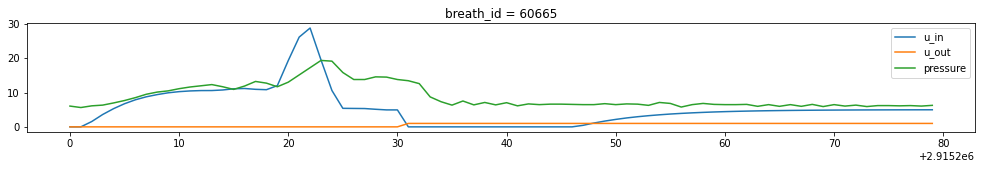

In [10]:
import random

for i in range(5):
  idx = random.choice(train['breath_id'].unique())
  train[train['breath_id'] == idx][[ 'u_in','u_out','pressure']].plot(figsize = (17,2), title = 'breath_id = {}'.format(idx))

Check how many breaths (rows) are in unique breath_id

In [11]:
train['breath_id'].value_counts().unique()[0]

80

# prepare data

Let's drop ID's

In [12]:
train = train.iloc[:,1:]
test = test.iloc[:,1:]

# Scaler

Let's fit and scale transform df

In [13]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0, 1))
train = pd.DataFrame(scaler.fit_transform(train), columns = train.columns)
train.head()

,breath_id,R,C,time_step,u_in,u_out,pressure
0,0.0,0.333333,1.0,0.000000,0.000833,0.0,0.115911
1,0.0,0.333333,1.0,0.011457,0.183830,0.0,0.116965
2,0.0,0.333333,1.0,0.022986,0.225093,0.0,0.146470
3,0.0,0.333333,1.0,0.034571,0.228088,0.0,0.204426
4,0.0,0.333333,1.0,0.046219,0.253559,0.0,0.211802


Let's first add 0's pressure coulmn to test to adjust a shape for scaling and then let's scale

In [14]:
test['pressure'] = 0
print(test.shape)
print(train.shape)

(4024000, 7)
(6036000, 7)


In [15]:
test = pd.DataFrame(scaler.transform(test), columns = test.columns)
test.head()

,breath_id,R,C,time_step,u_in,u_out,pressure
0,-0.000008,0.0,0.25,0.000000,0.000000,0.0,0.028415
1,-0.000008,0.0,0.25,0.010862,0.075150,0.0,0.028415
2,-0.000008,0.0,0.25,0.021730,0.146517,0.0,0.028415
3,-0.000008,0.0,0.25,0.032599,0.212306,0.0,0.028415
4,-0.000008,0.0,0.25,0.043457,0.263210,0.0,0.028415


Let's remove pressure to retrive primary shape

In [16]:
test.drop('pressure', axis = 1, inplace = True)

# Train test split

In [17]:
separator = int(0.8 * len(train))

X_train = train.iloc[:separator,:-1]
y_train = train.iloc[:separator,-1:]
X_test = train.iloc[separator:,:-1]
y_test= train.iloc[separator:,-1:]

# RNN

reshape (samples, timestep, features)

In [18]:
print('before reshaping:')
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print('\n')

X_train = X_train.to_numpy()
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])

y_train = y_train.to_numpy()
y_train = y_train.reshape(y_train.shape[0], 1, y_train.shape[1])

X_test = X_test.to_numpy()
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

y_test = y_test.to_numpy()
y_test = y_test.reshape(y_test.shape[0], 1, y_test.shape[1])

print('after reshaping:')
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

before reshaping:
(4828800, 6)
(4828800, 1)
(1207200, 6)
(1207200, 1)


after reshaping:
(4828800, 1, 6)
(4828800, 1, 1)
(1207200, 1, 6)
(1207200, 1, 1)


Model

In [29]:
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Input
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(LSTM(50))
model.add(Dense(1))

Compile

In [31]:
model.compile(optimizer='adam', loss='mean_absolute_error')
history = model.fit(X_train, y_train, batch_size=64, epochs=5)

Epoch 1/5
75450/75450 [==============================] - 281s 4ms/step - loss: 0.0368
Epoch 2/5
75450/75450 [==============================] - 276s 4ms/step - loss: 0.0354
Epoch 3/5
75450/75450 [==============================] - 275s 4ms/step - loss: 0.0341
Epoch 4/5
75450/75450 [==============================] - 274s 4ms/step - loss: 0.0336
Epoch 5/5
75450/75450 [==============================] - 270s 4ms/step - loss: 0.0332


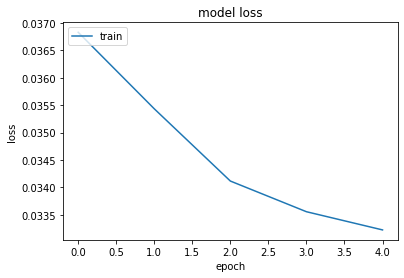

In [32]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [33]:
model.save('model')

INFO:tensorflow:Assets written to: model/assets


INFO:tensorflow:Assets written to: model/assets


In [34]:
model.evaluate(X_test, y_test)

37725/37725 [==============================] - 98s 3ms/step - loss: 0.0333


0.033313263207674026

# Prediction

In [35]:
from tensorflow import keras
model = keras.models.load_model('model')

In [36]:
test = test.to_numpy()
test = test.reshape(test.shape[0], 1,test.shape[1])
test.shape

(4024000, 1, 6)

In [37]:
test_predictions = model.predict(test)

In [38]:
test_predictions

array([[0.12750047],
       [0.13775744],
       [0.1314272 ],
       ...,
       [0.12120711],
       [0.12137771],
       [0.12159555]], dtype=float32)

In [39]:
test_2 = pd.read_csv('test.csv')
test_2.drop('id', axis = 1, inplace = True)
test_2['pressure'] = 0
names = test_2.columns
test_2 = scaler.transform(test_2)
test_2 = pd.DataFrame(data = test_2, columns = names)
test_2.head(2)

,breath_id,R,C,time_step,u_in,u_out,pressure
0,-0.000008,0.0,0.25,0.000000,0.00000,0.0,0.028415
1,-0.000008,0.0,0.25,0.010862,0.07515,0.0,0.028415


In [40]:
test_2['pressure'] = test_predictions
test_2.head(2)

,breath_id,R,C,time_step,u_in,u_out,pressure
0,-0.000008,0.0,0.25,0.000000,0.00000,0.0,0.127500
1,-0.000008,0.0,0.25,0.010862,0.07515,0.0,0.137757


In [41]:
test_2 = pd.DataFrame(data = scaler.inverse_transform(test_2), columns = names)
test_2.head(2)

,breath_id,R,C,time_step,u_in,u_out,pressure
0,0.0,5.0,20.0,0.000000,0.000000,0.0,6.610671
1,0.0,5.0,20.0,0.031904,7.515046,0.0,7.294982


# Submission

In [42]:
sample_submission['pressure'] = test_2['pressure']
sample_submission.head(2)

,id,pressure
0,1,6.610671
1,2,7.294982


In [43]:
pressure = sample_submission['pressure'].to_list()
pressure1 = []
for i in range(len(pressure)):
  if pressure[i] < 0:
    pressure1.append(-pressure[i])
  else:
    pressure1.append(pressure[i])

sample_submission['pressure'] = pressure1
sample_submission.head()

,id,pressure
0,1,6.610671
1,2,7.294982
2,3,6.872649
3,4,8.303846
4,5,10.031112


In [ ]:
!kaggle competitions submit -c ventilator-pressure-prediction -f sample_submission.csv -m "submission"

In [54]:
sample_submission.to_csv('ss', index = False)

In [53]:
pd.read_csv('ss')

,id,pressure
0,1,6.610671
1,2,7.294982
2,3,6.872649
3,4,8.303846
4,5,10.031112
...,...,...
4023995,4023996,6.176300
4023996,4023997,6.182218
4023997,4023998,6.190799
4023998,4023999,6.202181
